# Fitting a simple DCER to _Drosophila_

Consider the unweighted, symmetrized, loopless right _Drosophila_ larva connectome from Eichler et al (original one) 

Note that you will need to be in the graph model branch to run this in GraSPy

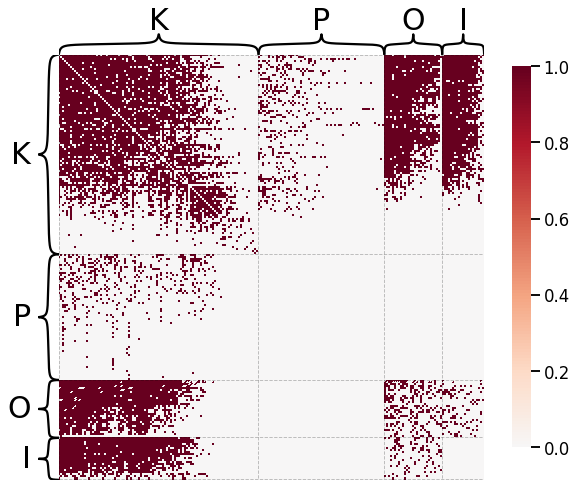

In [1]:
import numpy as np 
from graspy.datasets import load_drosophila_right
from graspy.plot import heatmap
from graspy.utils import binarize, symmetrize
import matplotlib.pyplot as plt
%matplotlib inline
adj, labels = load_drosophila_right(return_labels=True)
adj = symmetrize(adj, method='avg')
adj = binarize(adj)
heatmap(adj, inner_hier_labels=labels, transform='simple-nonzero');

### Fitting an ER model using the class in GraSPy

ER "p" parameter: 0.2479666732791113


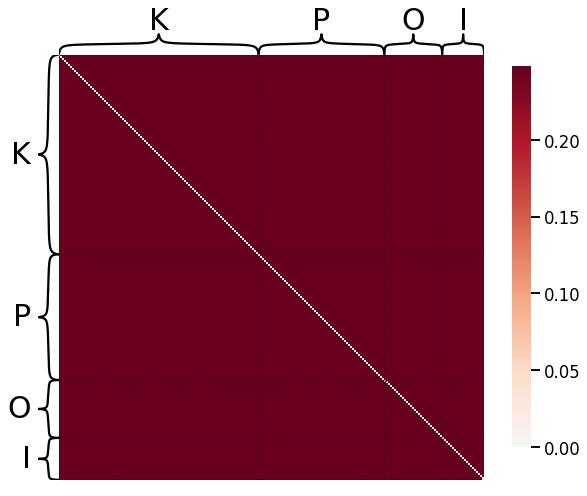

In [2]:
from graspy.models import EREstimator
er = EREstimator(directed=True,loops=False)
er.fit(adj)
print(f"ER \"p\" parameter: {er.p_}")
heatmap(er.p_mat_, inner_hier_labels=labels,);

### Fitting a DCER

$$P_{ij} = \theta_i \theta_j p$$
where $\theta$ is a length $n$ vector of degree corrections

Literature, though derived for *Possion* DCSBMs says to do the following to fit:

$k_i$ = degree of node $i$

$m$ = sum of edges in graph 

$\kappa_{\tau_i}$ would be sum of edges within block of node $i$ but here we have one block so this is just $m$

constrain $\theta$ to sum to 1

$$\hat{\theta_i} = \frac{k_i}{\kappa_{\tau_i}} = \frac{k_i}{m}$$
$$\hat{p} = m$$

Note that $p$ here is no longer really a probability in the ER sense

$$\hat{P_{ij}} = \hat{\theta_i}\hat{\theta_j}\hat{p} = \frac{k_i}{m} \frac{k_j}{m} m = \frac{k_i k_j}{m}$$

This is essentially what we have implemented in GraSPy but we get:

ER "p" parameter: 11250.0


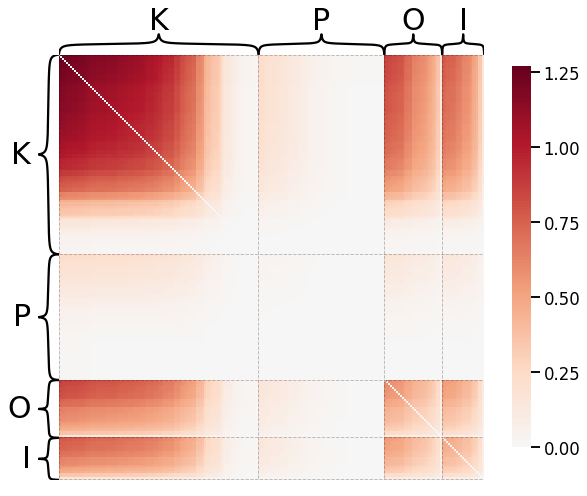

In [3]:
from graspy.models import DCEREstimator
dcer = DCEREstimator(directed=True,loops=False)
dcer.fit(adj)
print(f"ER \"p\" parameter: {dcer.p_}")
heatmap(dcer.p_mat_, inner_hier_labels=labels,);

# Define some funcs

In [4]:
def score_samples(p_mat, graph):
        """
        Compute the weighted log probabilities for each potential edge.

        Note that this implicitly assumes the input graph is indexed like the 
        fit model.

        Parameters
        ----------
        graph : np.ndarray
            input graph

        Returns
        -------
        sample_scores : np.ndarray (size of `graph`)
            log-likelihood per potential edge in the graph
        """
        p_mat = p_mat.copy()
        successes = np.multiply(p_mat, graph)
        failures = np.multiply((1 - p_mat), (1 - graph))
        likelihood = successes + failures
        return np.log(likelihood)
    
def score(p_mat, graph):
        """
        Compute the average log-likelihood over each potential edge of the 
        given graph.

        Note that this implicitly assumes the input graph is indexed like the 
        fit model.

        Parameters
        ----------
        graph : np.ndarray
            input graph

        Returns
        -------
        score : float
            sum of log-loglikelihoods for each potential edge in input graph
        """
        return np.sum(score_samples(p_mat, graph))
    
def score_samples_squishy(p_mat, graph):
        """
        Compute the weighted log probabilities for each potential edge.

        Note that this implicitly assumes the input graph is indexed like the 
        fit model.

        Parameters
        ----------
        graph : np.ndarray
            input graph

        Returns
        -------
        sample_scores : np.ndarray (size of `graph`)
            log-likelihood per potential edge in the graph
        """
        p_mat = p_mat.copy()
        
        # squish the probabilities that are degenerate
        c = 1 / graph.size
        p_mat[p_mat < c] = c
        p_mat[p_mat > 1 - c] = 1 - c
        successes = np.multiply(p_mat, graph)
        failures = np.multiply((1 - p_mat), (1 - graph))
        likelihood = successes + failures
        return np.log(likelihood)
    
def score_squishy(p_mat, graph):
        """
        Compute the average log-likelihood over each potential edge of the 
        given graph.

        Note that this implicitly assumes the input graph is indexed like the 
        fit model.

        Parameters
        ----------
        graph : np.ndarray
            input graph

        Returns
        -------
        score : float
            sum of log-loglikelihoods for each potential edge in input graph
        """
        return np.sum(score_samples_squishy(p_mat, graph))
     

### Method 1: Fit like in the literature (described above)

In [5]:
# This is what the current graspy class does
def fit_lit(adj):
    n_verts = adj.shape[0]
    m = np.sum(adj)
    p_mat = np.zeros((n_verts, n_verts))
    for i in range(n_verts):
        for j in range(n_verts):
            dj = np.sum(adj[j,:])
            di = np.sum(adj[i,:])
            p_mat[i, j] = dj * di / m
    p_mat = p_mat - np.diag(np.diag(p_mat))
    return p_mat, m

p = 11250.0
max = 1.2693333333333334
min = 0.0
likelihood = nan
squishy likelihood = -14516.75032111822


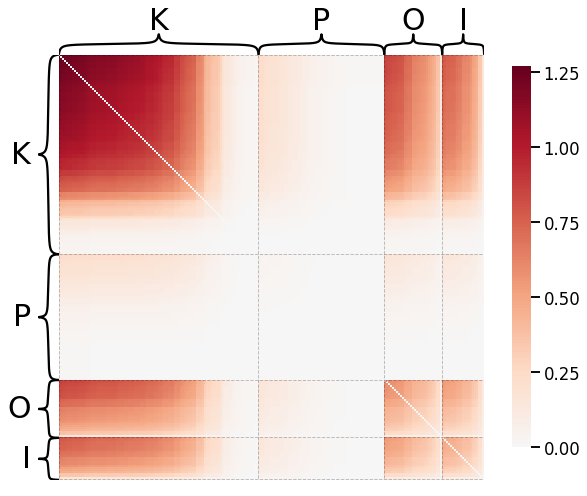

In [6]:
p_mat, p = fit_lit(adj)
print(f"p = {p}")
print(f"max = {p_mat.max()}")
print(f"min = {p_mat.min()}")
print(f"likelihood = {score(p_mat, adj)}")
print(f"squishy likelihood = {score_squishy(p_mat, adj)}")
heatmap(p_mat, inner_hier_labels=labels);

### Method 2: fit using MSE

Another option is to do the same thing to fit $\hat{\theta}$ as described above, but fit $\hat{p}$ by minimizing mean square error between the matrix $\hat{P}$ and the observed graph:

$$\lVert \hat{P} - A \rVert^2_F = \lVert \hat{\theta}\hat{\theta}^Tp - A \rVert^2_F$$

formulate like a linear regression: 
$Y$ is the adjacency matrix (0 or 1)
$p$ is a constant that we will fit 
$T$ is the outer product of $\hat{\theta}$ with itself
$$Y = p T$$
just use linear regression to fit p (below)

In [7]:
from sklearn.linear_model import LinearRegression

def fit_mse(adj,):
    n_verts = adj.shape[0]
    p_mat = np.zeros((n_verts, n_verts))
    m = adj.sum()
    for i in range(n_verts):
        for j in range(n_verts):
            dj = np.sum(adj[j,:]) / m
            di = np.sum(adj[i,:]) / m
            p_mat[i, j] = dj * di
    lr = LinearRegression(fit_intercept=False)
    p_mat = p_mat - np.diag(np.diag(p_mat))
    lr.fit(p_mat.ravel()[:,np.newaxis], adj.ravel()[:,np.newaxis])
    p = lr.coef_[0,0]
    p_mat = p_mat * p
    return p_mat, p

p = 11192.050031476614
max = 1.262794859847791
min = 0.0
likelihood = nan
squishy likelihood = -14496.078130607755


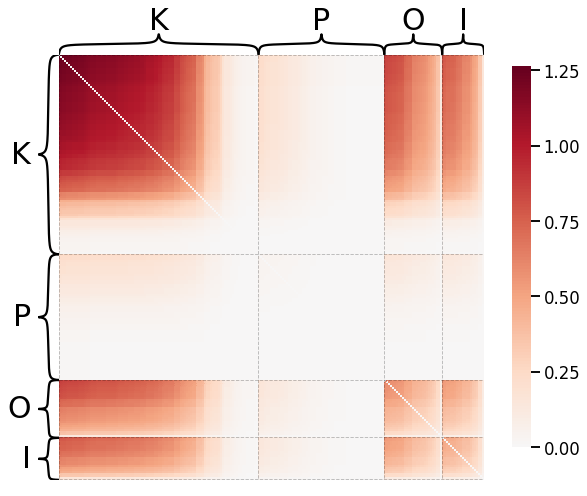

In [8]:
p_mat, p = fit_mse(adj)
print(f"p = {p}")
print(f"max = {p_mat.max()}")
print(f"min = {p_mat.min()}")
print(f"likelihood = {score(p_mat, adj)}")
print(f"squishy likelihood = {score_squishy(p_mat, adj)}");
heatmap(p_mat, inner_hier_labels=labels);

The fit parameter $\hat{p}$ is very similar to that found with method 1

### Method 3: fit MLE kinda?

Fit $\hat{\theta}$ as before
Fit $\hat{p}$ by maximizing the likelihood of observing the graph given the model
$$f(A | \theta, p) = \prod_{i \neq j} (\theta_i \theta_j p)^{A_{ij}} (1 - \theta_i \theta_j p)^{1 - A_{ij}}$$
$$\hat{p} = argmax_p \prod_{i \neq j} (\hat{\theta_i} \hat{\theta_j} p)^{A_{ij}} (1 - \hat{\theta_i} \hat{\theta_j} p)^{1 - A_{ij}}$$

Here I just do that numerically (constrained so that p is in [0,1])

In [9]:
from scipy.optimize import minimize_scalar

def likelihood(c, p_mat, adj):
    p_mat = p_mat.copy()
    p_mat *= c
    lik = score(p_mat, adj)
    return -lik

def fit_mle(adj,):
    n_verts = adj.shape[0]
    p_mat = np.zeros((n_verts, n_verts))
    m = adj.sum()
    for i in range(n_verts):
        for j in range(n_verts):
            dj = np.sum(adj[j,:]) / m 
            di = np.sum(adj[i,:]) / m
            p_mat[i, j] = dj * di
    p_mat = p_mat - np.diag(np.diag(p_mat))
    lik = lambda c : likelihood(c, p_mat, adj)
    res = minimize_scalar(lik, bounds=(0, 1/p_mat.max()), method="Bounded")
    p = res.x
    print(f"Optimized: {res.success}")
    p_mat = p_mat * p
    return p_mat, p

Optimized: True
p = 8862.919902593352
max = 0.9999999700466811
min = 0.0
squishy likelihood = -13889.701990720505
likelihood = -13889.697251809537


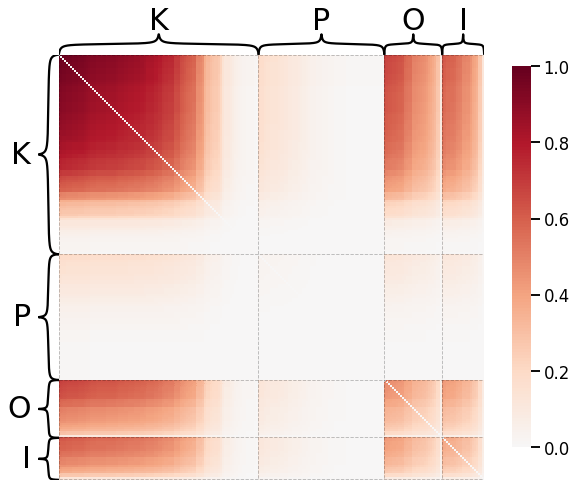

In [10]:
p_mat, p = fit_mle(adj)
heatmap(p_mat, inner_hier_labels=labels)
print(f"p = {p}")
print(f"max = {p_mat.max()}")
print(f"min = {p_mat.min()}")
print(f"squishy likelihood = {score_squishy(p_mat, adj)}");
print(f"likelihood = {score(p_mat, adj)}");


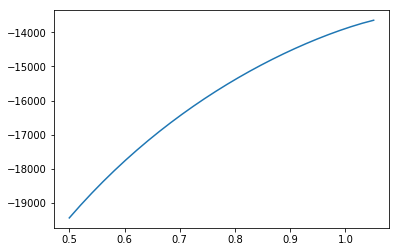

In [11]:
def plot_likelihood(p_mat):
    vals = np.linspace(0.5, 1.5, 50)
    outs = []
    for i in vals:
        out = score(p_mat*i, adj)
        outs.append(out)
    plt.plot(vals, outs)

plot_likelihood(p_mat)